# Centroid Search Experiment
This notebook demonstrates why using a spatial index is better than brute force searching for nearest nodes.

In [1]:
import geopandas as gpd
import osmnx as ox
from tqdm.notebook import tqdm

## Set Boundary

Load a shapefile containing the boundary of the city of Portland, ME.

In [2]:
portland_boundary = gpd.read_file(
    "https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=3857&f=json"
)

## Load Census Tracts for Portland, ME

In [3]:
tracts = (
    gpd.read_file("data/tl_2022_23_tract.zip")
    .set_index("GEOID")
    .to_crs("EPSG:3857")
    .clip(portland_boundary)
)

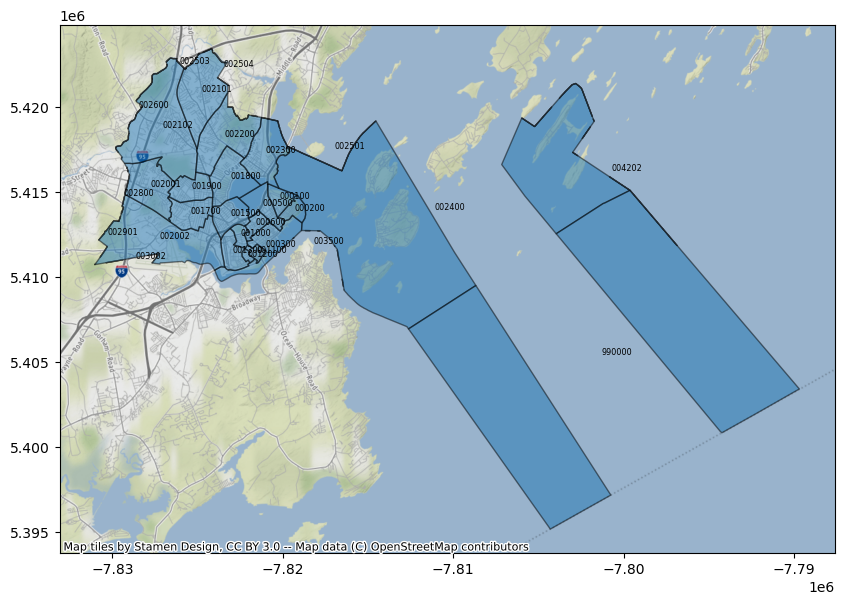

In [4]:
ax = tracts.plot(alpha=0.5, edgecolor="k")
for geoid in tracts.index:
    x, y = tracts.loc[geoid]["geometry"].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={"fontsize": "xx-small"})
cx.add_basemap(ax)

## Download and prep the street network

This is usually the most time-consuming step if the graph has not previously been downloaded. To speed things up, we check for a downloaded version first.

In [5]:
filepath = "./data/greater_portland.graphml"

if os.path.isfile(filepath):
    # load from file
    G = ox.load_graphml(filepath)
else:
    # download the street network
    bbox = tracts.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
    buffer = 0.05  # unit is lat/lon degrees
    network_type = "walk"
    G = ox.graph_from_bbox(
        bbox[3] + buffer,
        bbox[1] - buffer,
        bbox[2] + buffer,
        bbox[0] - buffer,
        network_type=network_type,
    )
    G = ox.project_graph(G, "EPSG:3857")  # project the graph to UTM for this zone
    ox.save_graphml(G, filepath)

Make sure this looks right.

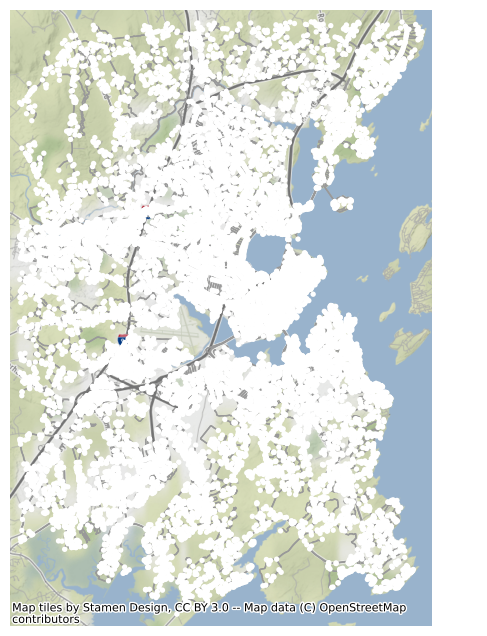

In [6]:
fig, ax = ox.plot_graph(G, bgcolor=None, show=False, close=False)
cx.add_basemap(ax)

We now need to find the nearest node (geographically) to each tract centroid. It turns out that this can be a computationally intensive task. Below, we are going to try three approaches:
1. Using the default OSMnx method.
2. Creating a geospatial index with Geopandas.

In [8]:
%%time
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes_1 = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids]
center_nodes_gdf_1 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes_1]

CPU times: user 2.28 s, sys: 8.57 ms, total: 2.29 s
Wall time: 2.28 s


In [9]:
%%time
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes_2 = gdf_nodes.loc[gdf_nodes.sindex.nearest(tracts.centroid)[1]]["osmid"].values
center_nodes_gdf_2 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes_2]

CPU times: user 359 ms, sys: 0 ns, total: 359 ms
Wall time: 357 ms


In [10]:
print(list(zip(center_nodes_1, center_nodes_2, strict=False)))

[(101311346, 101311346), (341524575, 341524575), (101523365, 101523365), (101383301, 101383301), (5334116504, 5334116504), (7679129568, 7679129568), (101366067, 101366067), (101474602, 101474602), (5386899213, 5386899213), (101425225, 101425225), (101303084, 101303084), (4564962915, 4564962915), (101642890, 101642890), (9668975098, 9668975098), (101675652, 101675652), (8251680278, 8251680278), (4670216769, 4670216769), (101477142, 101477142), (4518946206, 4518946206), (7964542144, 7964542144), (101625302, 101625302), (101602678, 101602678), (8287733051, 8287733051), (341474946, 341474946), (101450189, 101450189), (9018839719, 9018839719), (3077220970, 3077220970), (3097948611, 3097948611), (8286937529, 8286937529), (101354304, 101354304)]


Clearly, the spatial join approach is dramatically faster. We can visually verify results by plotting the two sets of nodes in red and blue with transparency such that any overlap appears magenta:

Text(0.5, 1.0, 'Visually Verifying Coordinates (Magenta = Overlapping Points)')

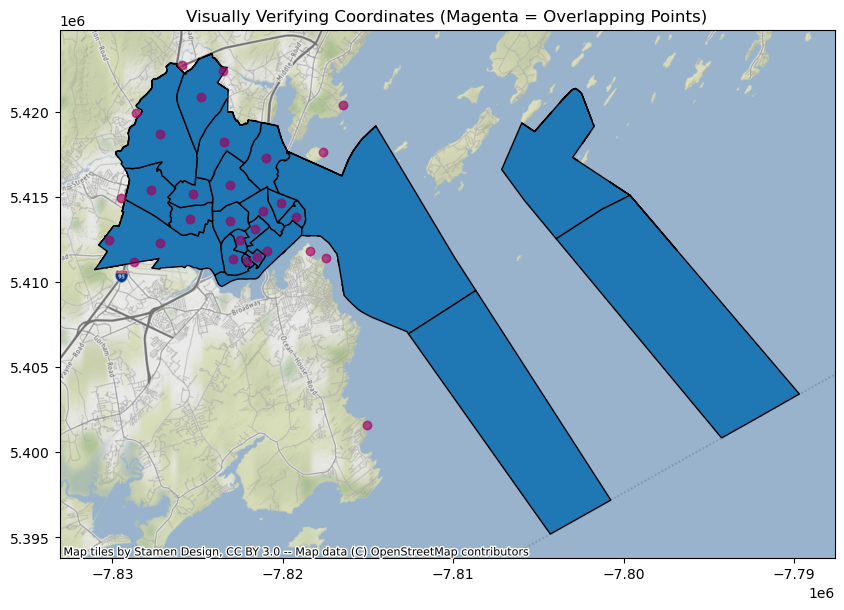

In [11]:
fig, ax = plt.subplots()
tracts.plot(ax=ax, edgecolor="k")
center_nodes_gdf_1.plot(ax=ax, color="b", alpha=0.4)
center_nodes_gdf_2.plot(ax=ax, color="r", alpha=0.4)
cx.add_basemap(ax)
ax.set_title("Visually Verifying Coordinates (Magenta = Overlapping Points)")

What happens if we repeat the experiment with an even larger graph - say, one of all of Maine?

In [12]:
filepath = "./data/maine.graphml"

if os.path.isfile(filepath):
    # load from file
    G = ox.load_graphml(filepath)
else:
    # download the street network
    network_type = "walk"
    G = ox.graph_from_place({"state": "Maine"}, network_type=network_type)
    ox.save_graphml(G, filepath)

G = ox.project_graph(G, "EPSG:3857")

In [13]:
%%time
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids]
center_nodes_gdf_1 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

CPU times: user 17 s, sys: 18 ms, total: 17.1 s
Wall time: 17.1 s


In [14]:
%%time
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes = gdf_nodes.loc[gdf_nodes.sindex.nearest(tracts.centroid)[1]]["osmid"].values
center_nodes_gdf_2 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

CPU times: user 2.28 s, sys: 0 ns, total: 2.28 s
Wall time: 2.28 s


Text(0.5, 1.0, 'Visually Verifying Coordinates (Magenta = Overlapping Points)')

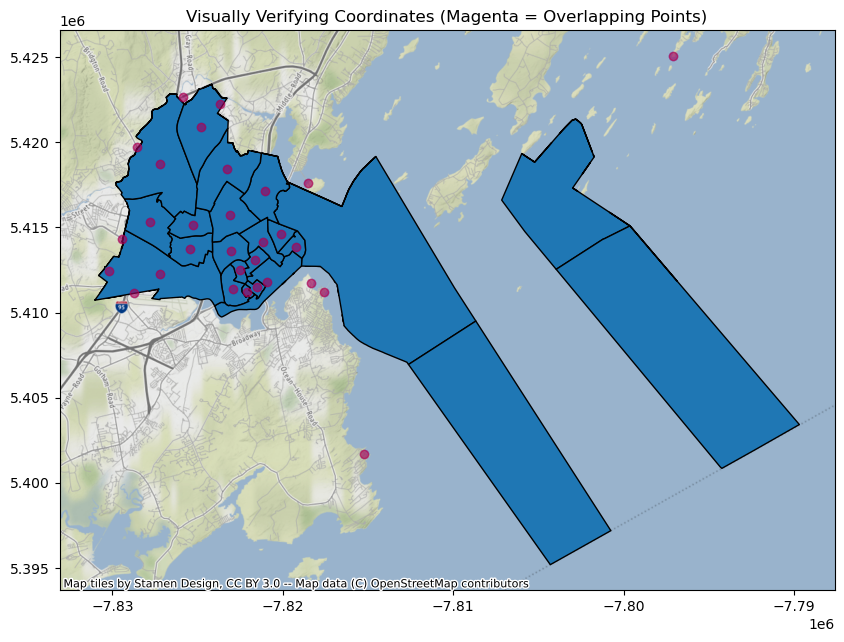

In [15]:
fig, ax = plt.subplots()
tracts.plot(ax=ax, edgecolor="k")
center_nodes_gdf_1.plot(ax=ax, color="b", alpha=0.4)
center_nodes_gdf_2.plot(ax=ax, color="r", alpha=0.4)
cx.add_basemap(ax)
ax.set_title("Visually Verifying Coordinates (Magenta = Overlapping Points)")

18 seconds isn't terrible, but that's just for one town's worth of Census tracts. What if we run it on Census tracts for the entire state?

In [16]:
tracts = gpd.read_file("data/tl_2022_23_tract.zip").set_index("GEOID").to_crs("EPSG:3857")

In [17]:
%%time
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes = []
for i in tqdm(range(len(centroids))):
    x, y = centroids[i]
    center_nodes.append(ox.distance.nearest_nodes(G, x[0], y[0]))
center_nodes_gdf_1 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

  0%|          | 0/407 [00:00<?, ?it/s]

CPU times: user 3min 38s, sys: 383 ms, total: 3min 38s
Wall time: 3min 38s


In [18]:
%%time
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes = gdf_nodes.loc[gdf_nodes.sindex.nearest(tracts.centroid)[1]]["osmid"].values
center_nodes_gdf_2 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

CPU times: user 4.63 s, sys: 107 µs, total: 4.63 s
Wall time: 4.62 s


Note: The performance of the spatial index gets even better with more queries. Now that the index exists, running the queries again is very fast.

In [20]:
%%time
print(gdf_nodes.has_sindex)
center_nodes = gdf_nodes.loc[gdf_nodes.sindex.nearest(tracts.centroid)[1]]["osmid"].values
center_nodes_gdf_2 = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

True
CPU times: user 1.75 s, sys: 19.9 ms, total: 1.77 s
Wall time: 1.77 s


At this rate, it would probably be possible to extend this experiment to the entire US. However, doing so would require a lot more memory, so we'll save that experiment for another day.